#Step 1: Import the neuron module into Python


In [1]:
import neuron
print(neuron.__version__)

7.7.2


In [2]:
from neuron import h,rxd
from neuron.units import ms, mV
import textwrap

#Step 2: Create a cell 

##Aside 1: NEURON's h.topology function
NEURON's h.topology() function displays the topological structure of the entire model, indicating which sections are connected to which sections, where they are connected, and how many segments each section is divided into.


In [3]:

soma = h.Section(name = 'soma')
h.topology()


|-|       soma(0-1)



1.0

##Aside 2: The psection method
Every NEURON section has a psection method (think: properties of the section) that returns a Python dictionary providing a structured data representation of the properties of the section.

For example, we can query the soma via:

In [4]:
print(soma.psection())

{'point_processes': {}, 'density_mechs': {}, 'ions': {}, 'morphology': {'L': 100.0, 'diam': [500.0], 'pts3d': [], 'parent': None, 'trueparent': None}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'soma', 'hoc_internal_name': '__nrnsec_0x112884000', 'cell': None}


The results tell us the soma is a cylinder with length 100 microns, diameter 500 microns, axial resistivity 35.4 ohm*cm, and specific membrance capacitance 1 μF/cm2.

Note: calling this method does not itself print anything to the screen. Instead it returns a dictionary. We see the contents of the dictionary only because we are running interactively; from a script, nothing would be printed unless we explicitly printed it with print, or, better pretty-printed it with pprint.pprint.

Since this is a dictionary, we can extract any properties we want using square brackets. For example, the length of the section is:

In [5]:
print(soma.psection()['morphology']['L'])

100.0


All of these values can be individually accessed in more efficient ways, but psection provides an overview of the full properties of the section.
For example, the length of the soma is more efficiently available (and settable) via:

In [6]:
print(soma.L)

100.0


soma.psection()['morphology']['diam'] is a list (of length 1 here), with each entry corresponding to the value for each segment. Similarly for soma.psection()['cm'], etc.

**Important**: You may have noticed that the default diameter is 500 μm, which is excessively large for mammalian neurons. It's the default because it's appropriate for the squid giant axons studied by Hodgkin and Huxley. NEURON also uses squid-relevant values for axial resistivity (soma.Ra) and temperature (h.celsius). These should all be adjusted for mammalian models.

#Step 3: Set the cell's morphological properties
Since we're simulating a soma, the default length of 100 μm and diameter of 500 μm are inappropriate. Let's set the length (L) and diameter (diam) to **20 μm** instead:

In [7]:
soma.L = 20
soma.diam = 20
print(soma.L)
print(dir(soma))

20.0
['L', 'Ra', '__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'allseg', 'arc3d', 'cell', 'children', 'connect', 'diam3d', 'has_membrane', 'hname', 'hoc_internal_name', 'insert', 'is_pysec', 'n3d', 'name', 'nseg', 'orientation', 'parentseg', 'psection', 'pt3dadd', 'pt3dchange', 'pt3dclear', 'pt3dinsert', 'pt3dremove', 'pt3dstyle', 'push', 'rallbranch', 'same', 'spine3d', 'subtree', 'trueparentseg', 'uninsert', 'wholetree', 'x3d', 'y3d', 'z3d']


##Aside 3: Python's dir function

print(textwrap.fill(', '.join(dir(h))))
###### Give features (list given by dir in multiples rows)


#Step 4: Insert ion channels
Let's insert Hodgkin-Huxley channels into the soma's membrane. We do this by passing 'hh' as the mechanism type:

In [8]:
soma.insert('hh')

soma

The section is returned so that multiple insertions can be chained together if desired.
We note that Hodgkin-Huxley channel kinetics are based on the squid giant axon. If that's not your model organism, then for your actual modeling projects, you'll want to use other kinetics, either by downloading them from online resources like ModelDB or by writing them yourself in NMODL or NeuroML.

##Aside 5: Sections and segments
A NEURON Section is considered a piece of cable. Depending on the resolution desired, it may be necessary to divide the cable into a number of segments where voltage varies linearly between centers of adjacent segments. The number of segments within a section is given by the variable, nseg. The total ionic current across the segment membrane is approximately the area of the segment multiplied by the ionic current density at the center of the segment. To access a part of the section, specify a value between 0 and 1, where 0 is typically the end closest to the soma and 1 is the distal end. Because nseg divides the cable into equal-length parts, it should be an odd number so that to address the middle of the cable, (0.5), gives the middle segment.

##Aside 6: Accessing segment variables
Segment variables follow the idiom:

_section(loc).var_

And for mechanisms on the segment:

_section(loc).mech.var_

or

_section(loc).var_mech_

**The first form is preferred.**

In [9]:
mech = soma(0.5).hh
print(dir(mech))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'el', 'gk', 'gkbar', 'gl', 'gna', 'gnabar', 'h', 'il', 'is_ion', 'm', 'n', 'name', 'segment']


In [10]:
print(mech.gkbar)
print(soma(0.5).hh.gkbar)

0.036
0.036


#Step 5: Insert a stimulus
Let's insert a current clamp (an IClamp object) into the center of the soma to induce some membrane dynamics.

In [11]:
iclamp = h.IClamp(soma(0.5))
print([item for item in dir(iclamp) if not item.startswith('__')])

['amp', 'baseattr', 'delay', 'dur', 'get_loc', 'get_segment', 'has_loc', 'hname', 'hocobjptr', 'i', 'loc', 'same']


An IClamp is a Point Process. Point processes are point sources of current. When making a new PointProcess, you pass the segment to which it will bind.

Again, with the dir function, we can validate that iclamp is an object and contains some useful parameters. Let's look at some of those parameters. We use a list comprehension to ignore those elements of the dir that start with double underscores (and are thus Python magic methods and not functions/variables intended to be used directly).

In [12]:
print([item for item in dir(iclamp) if not item.startswith('__')])

['amp', 'baseattr', 'delay', 'dur', 'get_loc', 'get_segment', 'has_loc', 'hname', 'hocobjptr', 'i', 'loc', 'same']


In particular, we notice three key properties of a current clamp: amp -- the amplitude (in nA), delay -- the time the current clamp switches on (in ms), and dur -- how long (in ms) the current clamp stays on. Let's set these values:

In [13]:
iclamp.delay = 2
iclamp.dur = 0.1
iclamp.amp = 0.9

Let's use psection to get a representation of the soma model:

In [14]:
print(soma.psection())

{'point_processes': {'IClamp': {IClamp[0]}}, 'density_mechs': {'hh': {'gnabar': [0.12], 'gkbar': [0.036], 'gl': [0.0003], 'el': [-54.3], 'gna': [0.0], 'gk': [0.0], 'il': [0.0], 'm': [0.0], 'h': [0.0], 'n': [0.0]}}, 'ions': {'na': {'ena': [50.0], 'nai': [10.0], 'nao': [140.0], 'ina': [0.0], 'dina_dv_': [0.0]}, 'k': {'ek': [-77.0], 'ki': [54.4], 'ko': [2.5], 'ik': [0.0], 'dik_dv_': [0.0]}}, 'morphology': {'L': 20.0, 'diam': [20.0], 'pts3d': [], 'parent': None, 'trueparent': None}, 'nseg': 1, 'Ra': 35.4, 'cm': [1.0], 'regions': set(), 'species': set(), 'name': 'soma', 'hoc_internal_name': '__nrnsec_0x112884000', 'cell': None}


#Step 6: Set up recording variables
The cell should be configured to run a simulation. However, we need to indicate which variables we wish to record; these will be stored in a NEURON Vector (h.Vector object). For now, we will record the membrane potential, which is soma(0.5).v and the corresponding time points (h.t). References to variables are available by preceding the last part of the variable name with a _ref_

In [15]:
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector
print(v)
print(t)


Vector[0]
Vector[1]


# Step 7: Run the simulation (yeaaah)
By default, the NEURON h module provides the low level fadvance function for advancing one time step. For higher-level simulation control specification, we load NEURON's stdrun library:

In [16]:
print(h.load_file('stdrun.hoc'))

1.0


We can then initialize our simulation such that our cell has a resting membrane potential of -70 mV:

In [17]:
h.finitialize(-70 * mV)

1.0

And now continue the simulation from the current time (0) until 40 ms:

In [18]:
print(h.continuerun(40))

0.0


# Step 8: Plot the results (^^)

## Using boken
When working in Jupyter with an active internet connection, it is often convenient to use the bokeh module for plotting, as it provides interactive graphs that can be panned, zoomed, and saved from the Jupyter notebook.
Let's load bokeh and tell it to output to the Jupyter notebook:

In [19]:
from bokeh.io import output_notebook
import bokeh.plotting as plt
output_notebook()

Loading BokehJS ...

Now we plot membrane potential vs time.

In [20]:
f = plt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, v, line_width=2)
plt.show(f)

Using matplotlib

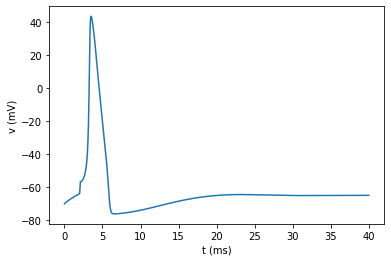

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

# Step 8 : Saving the result

### Writing

In [22]:
import csv
with open('data.csv', 'w') as f:
    csv.writer(f).writerows(zip(t, v))
    

Reading

In [23]:
with open('data.csv') as f:
    reader = csv.reader(f)
    tnew, vnew = zip(*[[float(val) for val in row] for row in reader if row])

The argument to the zip is a nested list comprehension; the zip and the asterisk together effectively transpose the data turning it from a list of (t, v) pairs into a list of t values and a list of v values. For loading more variables, the right hand side of the last line is unchanged; all that changes is that the variables need to be listed on the left; e.g. tnew, vnew, canew = zip(...)

We can plot our newly loaded data (here with matplotlib) to see that it is the same as before:

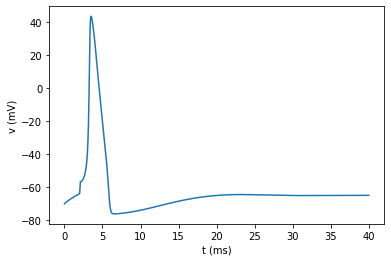

In [24]:
plt.figure()
plt.plot(tnew, vnew)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Reading and plotting using plotnine and pandas:

The modules plotnine and pandas are key components of the Python data science ecosystem. We can use them to work with our NEURON data, but they may have to be installed separately.

First, we'll load the modules. It is common to use shortened names for the modules, but this is not necessary:

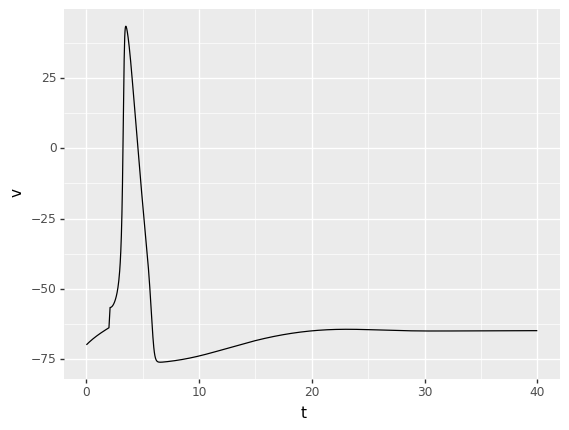

In [25]:
import plotnine as p9
import pandas as pd

data = pd.read_csv('data.csv', header=None, names=['t', 'v'])
g = (p9.ggplot(data, p9.aes(x='t', y='v')) + p9.geom_path()).draw()

## Json
JSON is used for structured data interchange. It is a newer but widely used format and libraries for reading and writing JSON exist for most programming languages.

Python provides the json module to simplify reading and writing JSON files. We load it via:

In [26]:
import json

Writing

In [27]:
with open('data.json', 'w') as f:
    json.dump({'t': list(t), 'v': list(v)}, f, indent=4)
    

Here we built a dictionary with keys t and v, and stored their values as a list. Since JSON is a language-independent format, it does not have a concept of NEURON Vectors, which is why we had to create a list copy of them before saving. The indent=4 argument is optional, but indents the output to make it more human-readable (at the cost of a larger file size).

# Reading

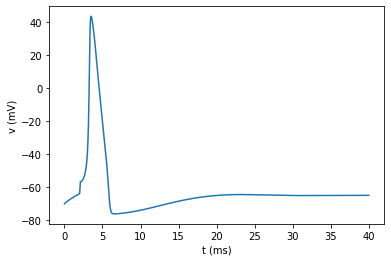

In [28]:
with open('data.json') as f:
    data = json.load(f)
tnew = data['t']
vnew = data['v']

plt.figure()
plt.plot(tnew, vnew)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Pickles

In [29]:
import pickle

In [30]:
with open('data.p', 'wb') as f:
    pickle.dump({'t': t, 'v': v}, f)

with open('data.p', 'rb') as f:
    data = pickle.load(f)
tnewp = data['t']
vnewp = data['v']
type(tnewp)
tnewp.hname()

'Vector[2]'

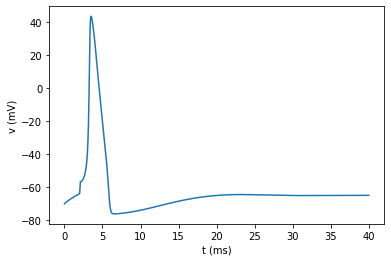

In [31]:
plt.figure()
plt.plot(tnewp, vnewp)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

# Tutorial's end

Exercice 5 :

In [76]:
h.load_file('mosinit.hoc')

1.0

In [85]:
print(textwrap.fill(', '.join(dir(h))))

APCount, AlphaSynapse, AtolTool, AtolToolItem, BBSaveState, CVode,
DEG, Deck, E, ExecCommand, Exp2Syn, ExpSyn, FARADAY,
FInitializeHandler, File, GAMMA, GUIMath, Glyph, Graph, HBox, IClamp,
Impedance, IntFire1, IntFire2, IntFire4, KSChan, KSGate, KSState,
KSTrans, L, LinearMechanism, List, Matrix, MechanismStandard,
MechanismType, NEURONMainMenu, NetCon, NetStim, NumericalMethodPanel,
OClamp, PHI, PI, PPShape, PWManager, ParallelContext, PatternStim,
Plot, PlotShape, PointBrowser, PointProcessMark, Pointer, PtrVector,
PythonObject, R, Ra, Random, RangeVarPlot, SEClamp, SaveState,
Section, SectionBrowser, SectionList, SectionRef, Shape, SingleChan,
StateTransitionEvent, String, StringFunctions, SymChooser, TQueue,
TextEditor, Timer, VBox, VClamp, ValueFieldEditor, Vector,
WindowGroup, WindowGroupItem, WindowGroupManager, WindowMenu, __abs__,
__add__, __bool__, __call__, __class__, __delattr__, __delitem__,
__dir__, __doc__, __eq__, __format__, __ge__, __getattribute__,
__getitem__, __gt

In [87]:
print(dir(soma))

['L', 'Ra', '__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'allseg', 'arc3d', 'cell', 'children', 'connect', 'diam3d', 'has_membrane', 'hname', 'hoc_internal_name', 'insert', 'is_pysec', 'n3d', 'name', 'nseg', 'orientation', 'parentseg', 'psection', 'pt3dadd', 'pt3dchange', 'pt3dclear', 'pt3dinsert', 'pt3dremove', 'pt3dstyle', 'push', 'rallbranch', 'same', 'spine3d', 'subtree', 'trueparentseg', 'uninsert', 'wholetree', 'x3d', 'y3d', 'z3d']


In [57]:
iclamp = h.IClamp(soma(0.5))
iclamp.delay = 2
iclamp.dur = 2

iclamp.amp = 0.9

In [98]:
v = h.Vector().record(soma(0.5)._ref_v)
vna = h.Vector().record(soma(0.5)._ref_ina)
vk = h.Vector().record(soma(0.5)._ref_ik)



In [99]:
# Membrane potential vector
t = h.Vector().record(h._ref_t) 

In [100]:
h.finitialize(-70 * mV)
h.continuerun(10 * ms)

0.0

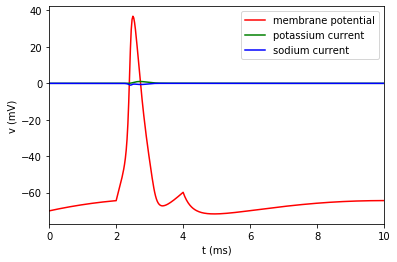

In [105]:
plt.figure()
plt.plot(t, v, color='r',label='membrane potential')
plt.plot(t, vk, color='g', label ='potassium current')
plt.plot(t, vna, color='b', label = 'sodium current')
plt.xlim(0,10)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()

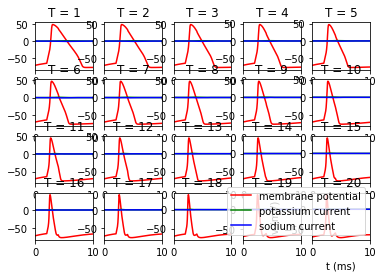

In [109]:
h.load_file('mosinit.hoc')


i = 0
for x in range(20):
    ax = plt.subplot(4,5,i+1)
    h.celsius = i
    iclamp = h.IClamp(soma(0.5))
    iclamp.delay = 2
    iclamp.dur = 2
    iclamp.amp = 0.9
    v = h.Vector().record(soma(0.5)._ref_v)   
    t = h.Vector().record(h._ref_t) 
    vna = h.Vector().record(soma(0.5)._ref_ina)
    vk = h.Vector().record(soma(0.5)._ref_ik)
    h.finitialize(-70 * mV)
    h.continuerun(10 * ms)
    i+=1
    ax.plot(t, v, color='r',label='membrane potential')
    ax.plot(t, vk, color='g', label ='potassium current')
    ax.plot(t, vna, color='b', label = 'sodium current')
    ax.set_xlim([0, 10])
    ax.set_title("T = "+ str( i ))
#plt.title("Membrane potential, sodium current, and potassium current as functions of time")
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()    


In [106]:
import csv
with open('ex5.csv', 'w') as f:
    csv.writer(f).writerows(zip(t, v, vk, vna))
    